In [1]:
# package(s) related to time, space and id
import datetime, time
import os
import io
import functools
import logging
import pickle
import random
import math

# package(s) related to the simulation
import enum
import simpy
import scipy as sc
import math
import networkx as nx  
import numpy as np
import pandas as pd
import re
import yaml as yaml
import time
import bisect
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import xarray as xr

from osgeo import gdal
from scipy import interpolate
from scipy.signal import correlate
from shapely.ops import transform,split,snap
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# OpenTNSim
from opentnsim import core
from opentnsim import plot
from opentnsim import model
from opentnsim import import_hydrodynamic_dataset
from opentnsim import vessel_traffic_service
from opentnsim import port
from opentnsim import lock
from opentnsim import vessel
from opentnsim import waterway
from opentnsim import output
from opentnsim import tidal_window_constructor
from opentnsim import rule_constructor
from opentnsim import regulations

# spatial libraries 
import shapely.geometry
from shapely.geometry import Point
import shapely.wkt
import pyproj
import folium
import datetime
import time as timepy

# package(s) for data handling
import requests

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# define the coorinate systemb
geod = pyproj.Geod(ellps="WGS84")

location_vessel_database = "Vessels/richtlijnen-vaarwegen-2017.csv"

In [2]:
Node = type('Site', (core.Identifiable, core.Log, core.Locatable, core.HasResource), {})
nodes = []
path = []
coords = []

coords.append([3.809821,51.337596]) #node_1
coords.append([3.824399,51.319057]) #node_2

for d in range(len(coords)):
    data_node = {"env": [],
                 "name": "Node_" + str(d+1),
                 "geometry": shapely.geometry.Point(coords[d][0], coords[d][1])}
    node = Node(**data_node)
    nodes.append(node)
    
for i in range(len(nodes)-1):
    path.append([nodes[i],nodes[i+1]]) 
    path.append([nodes[i+1],nodes[i]])

FG = nx.MultiDiGraph()

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

for edge in path:
    geometry = shapely.geometry.LineString([FG.nodes[edge[0].name]['geometry'],FG.nodes[edge[1].name]['geometry']])
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {},geometry=geometry)
    
for node in FG.nodes:
    FG.nodes[node]['Info'] = {}

In [3]:
wgs = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:28992')
wgs_to_utm = pyproj.Transformer.from_crs(wgs,utm,always_xy=True).transform
utm_to_wgs = pyproj.Transformer.from_crs(utm,wgs,always_xy=True).transform

In [4]:
for node in FG.nodes:
    FG.nodes[node]['geometry'] = transform(wgs_to_utm,FG.nodes[node]['geometry'])
    
for edge in FG.edges:
    geometry = transform(wgs_to_utm,FG.edges[edge]['geometry'])
    length = geometry.length
    FG.edges[edge]['geometry'] = geometry
    FG.edges[edge]['Info']['geometry'] = geometry
    FG.edges[edge]['Info']['length'] = length

In [5]:
import pytz
simulation_start = datetime.datetime(2019,1,1,0,0,0)
duration = pd.Timedelta(365*24*3600,'s') #seconds

In [6]:
water_level = []
salinity = []

for nodes in enumerate(FG.nodes):
    water_level.append([[],[]])
    salinity.append([[],[]])

MBL = [11,11]
depth = MBL
times = np.arange(simulation_start,simulation_start+duration,datetime.timedelta(seconds=10*60))
stations = list(FG.nodes)

for node in enumerate(list(FG.nodes)):
    if not node[0]:
        water_level[node[0]]=[1.0*np.sin(2*np.pi*((t-np.datetime64(0,'s'))/np.timedelta64(1, 's')-simulation_start.timestamp())/45000) for t in times]
        salinity[node[0]]=[30.0 for t in times]
    else:
        water_level[node[0]]=[0.0 for t in times]
        salinity[node[0]]=[0.0 for t in times]

In [7]:
import xarray as xr
station_data = xr.DataArray(data=stations,
                         dims=["STATIONS"])

time_data = xr.DataArray(data=times,
                         dims=["TIME"])

MBL_data = xr.DataArray(data=MBL,
                        dims=["STATIONS"])

depth_data = xr.DataArray(data=depth,
                          dims=["STATIONS"])

water_level_data = xr.DataArray(data=[wlev for wlev in water_level],
                                dims=["STATIONS","TIME"])

salinity_data = xr.DataArray(data=[sal for sal in salinity],
                             dims=["STATIONS","TIME"])

hydrodynamic_data = xr.Dataset({'TIME':times,
                                'Stations':station_data,
                                'MBL':MBL_data,
                                'Depth':depth_data,
                                'Water level': water_level_data,
                                'Salinity':salinity_data})

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_6244\3095883058.py:5: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_6244\3095883058.py:20: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by conve

In [8]:
sim = model.Simulation(graph=FG,simulation_start=simulation_start,simulation_duration=duration,hydrodynamic_data=hydrodynamic_data)
env = sim.environment

In [9]:
sim.environment.vessel_traffic_service

In [10]:
lock_1 = lock.IsLock(env = sim.environment, 
                     name = 'Lock',
                     distance_doors1_from_first_waiting_area=1000,   
                     distance_doors2_from_second_waiting_area=1000,
                     node_doors1 = "Node_1", node_doors2 = "Node_2",
                     lock_length = FG.edges['Node_1','Node_2',0]['Info']['length']-2000, lock_width = 40, lock_depth = 10.5, 
                     doors_open = 600, doors_close = 600, disch_coeff = 0.8,mandatory_time_gap_between_entering_vessels=0,
                     opening_area = 4.0, opening_depth = 5.0,node_open='Node_2',
                     detector_nodes=['Node_1','Node_2'], priority_rules = regulations.ConditionalRule('start_node','==','Node_2'))

lineup_area_1 = lock.IsLockLineUpArea(env = sim.environment, name = 'Lock', distance_to_lock_doors = 0,
                                      start_node = "Node_1",end_node = "Node_2", lineup_length = 300)

lineup_area_2 = lock.IsLockLineUpArea(env = sim.environment, name = "Lock", distance_to_lock_doors = 0,
                                      start_node = "Node_2",end_node = "Node_1", lineup_length = 300)

waiting_area_1 = lock.IsLockWaitingArea(env = sim.environment, name = 'Lock', distance_from_node=0,
                                        node = "Node_1")
    
waiting_area_2 = lock.IsLockWaitingArea(env = sim.environment, name = "Lock", distance_from_node=0,
                                        node = "Node_2")

c:\users\floorbakker\opentnsim\opentnsim\lock.py:326: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



In [11]:
Vessel = type('Vessel', 
              (core.SimpyObject, core.Identifiable, lock.HasWaitingArea, lock.HasLock, lock.HasLineUpArea, core.Movable, vessel.VesselProperties, output.HasOutput, vessel.ExtraMetadata), {})

In [12]:
def create_vessel(name,FG,origin,destination,length,beam,draught,height,v,arrival_time):
    vessel_input = { "name":name,
                     "geometry":FG.nodes[origin]['geometry'],
                     "origin":origin,
                     "destination":destination,
                     #"next_destination":next_destination,
                     "route":nx.dijkstra_path(FG,origin,destination),
                     "env":env,
                     "type":'Tanker',
                     "B":beam,
                     "L":length,
                     "T": draught,
                     "H":height,
                     #"t_berthing":berthing_time.total_seconds(),
                     #"t_(un)loading":[time.total_seconds() for time in unloading_time],
                     #"t_turning":[time.total_seconds() for time in turning_time],
                     #"ukc":ukc,
                     "v":v,
                     #"terminal_of_call": terminal_of_call,
                     #"berth_of_call": berth_of_call,
                     #"(un)loading": delta_draught,
                     #"max_waiting_time":datetime.timedelta(days=10).total_seconds(),
                     #"max_cross_current":max_cross_current,
                     "arrival_time":arrival_time,
                     #"arrival_delay":arrival_time,
                     #"priority": 0,
                     #"additional_waiting_time": additional_waiting_time/np.timedelta64(1, 's'),
                     #"bound":bound,
                     #"priority":False
                   }
    return vessel_input

In [13]:
created_vessel = Vessel(**create_vessel(name = 'test_vessel_1',
                                        FG = FG,
                                        origin='Node_1',
                                        destination='Node_2',
                                        length=200,
                                        beam=35,
                                        draught=10,
                                        height=5,
                                        v=4,
                                        arrival_time=sim.environment.simulation_start))
sim.add_vessels(vessel=created_vessel)

created_vessel = Vessel(**create_vessel(name = 'test_vessel_2',
                                        FG = FG,
                                        origin='Node_2',
                                        destination='Node_1',
                                        length=200,
                                        beam=35,
                                        draught=10,
                                        height=5,
                                        v=4,
                                        arrival_time=sim.environment.simulation_start))
sim.add_vessels(vessel=created_vessel)

# created_vessel = Vessel(**create_vessel(name = 'test_vessel_3',
#                                         FG = FG,
#                                         origin='Node_1',
#                                         destination='Node_2',
#                                         length=200,
#                                         beam=35,
#                                         draught=10,
#                                         height=5,
#                                         v=6.5,
#                                         arrival_time=sim.environment.simulation_start+pd.Timedelta(10000,'s')))
# sim.add_vessels(vessel=created_vessel)



In [14]:
import time
datetime.datetime.fromtimestamp(time.mktime(sim.environment.simulation_start.timetuple()))

datetime.datetime(2019, 1, 1, 0, 0)

In [15]:
sim.run()

c:\users\floorbakker\opentnsim\opentnsim\lock.py:699: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:699: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

In [16]:
lock_df = pd.DataFrame(lock_1.log)
lock_df

,Time,Location,Action,Status
0,2019-01-01 00:00:00.000000,Node_2,Lock doors closing start,{}
1,2019-01-01 00:10:00.000000,Node_2,Lock doors closing stop,{}
2,2019-01-01 00:10:00.000000,Node_2,Lock chamber converting start,{}
3,2019-01-01 00:32:20.000000,Node_1,Lock chamber converting stop,{}
4,2019-01-01 00:32:20.000000,Node_1,Lock doors opening start,{}
5,2019-01-01 00:42:20.000000,Node_1,Lock doors opening stop,{}
6,2019-01-01 00:47:52.593802,Node_1,Lock doors closing start,{}
7,2019-01-01 00:57:52.593802,Node_1,Lock doors closing stop,{}
8,2019-01-01 00:57:52.593802,Node_1,Lock chamber converting start,{}
9,2019-01-01 01:25:42.593802,Node_2,Lock chamber converting stop,{}


In [17]:
vessels = sim.environment.vessels

In [18]:
sim.environment.run(sim.environment.process(lock_1.convert_chamber(sim.environment,lock_1.log['Location'][-1],0,vessels[-1])))

c:\users\floorbakker\opentnsim\opentnsim\lock.py:486: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



In [19]:
times = []
distances = []
positions = []

for _vessel_ in vessels:
    sailed_edges = []
    for edge in zip(_vessel_.route[:-1],_vessel_.route[1:]):
        sailed_edges.append(_vessel_.env.FG.edges[edge[0],edge[1],0]['geometry'])

    for loc,geom in enumerate(sailed_edges):
        if loc:
            multi_line = shapely.geometry.MultiLineString([geometry, geom])
            final_geometry = shapely.ops.linemerge(multi_line)
        else:
            final_geometry = geom
            
    vessel_time = []
    vessel_locations = []
    for loc,message in pd.DataFrame(_vessel_.log).iterrows():
        vessel_time.append(message.Time)
        vessel_locations.append(message.Location)
    
    vessel_distance = []
    for loc,location in enumerate(vessel_locations):
        if not loc:
            vessel_distance.append(0)
            continue
            
        geometries = split(snap(final_geometry, location, tolerance=100), location).geoms
        if len(geometries) > 1:
            vessel_distance.append(geometries[0].length)
        else:
            if loc >= len(vessel_locations)-2:
                vessel_distance.append(geometries[0].length)
            else:
                vessel_distance.append(vessel_distance[-1])
    
    if _vessel_.route[0] == 'Node_2':
        vessel_distance = [final_geometry.length-distance for distance in vessel_distance]
        
    times.append(vessel_time)
    distances.append(vessel_distance)
    positions.append(vessel_locations)

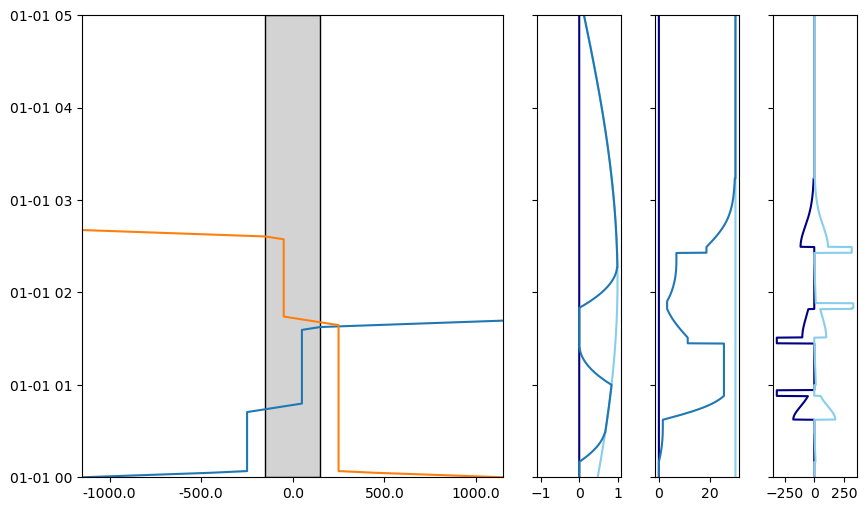

In [20]:
lock_outer_doors = lock_1.distance_doors1_from_first_waiting_area
lock_inner_doors = FG.edges['Node_1','Node_2',0]['geometry'].length-lock_1.distance_doors1_from_first_waiting_area

fig,axes = plt.subplots(1,4,figsize=[10,6],gridspec_kw = {'width_ratios':[5,1,1,1]})

ax = axes[0]
for time,distance in zip(times,distances):
    ax.plot(distance,time)

ax.set_xlim(min(map(min,distances)),max(map(max,distances)))
ax.set_ylim(min(map(min,times)),min(map(min,times))+pd.Timedelta(5,'h'))
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.fill([lock_outer_doors,lock_outer_doors,lock_inner_doors,lock_inner_doors],
        [ylim[0],ylim[1],ylim[1],ylim[0]],zorder=0,color='lightgrey',edgecolor='k')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
xticks = np.arange(xlim[0],xlim[1],500)+np.mean(xlim)-min(np.arange(xlim[0],xlim[1],500), key=lambda x:abs(x-np.mean(xlim)))
ax.set_xticks(xticks)
ax.set_xticklabels(xticks-np.mean(xticks))

ax = axes[1]
ax.plot(hydrodynamic_data.sel(STATIONS=0)['Water level'].values,
        hydrodynamic_data.sel(STATIONS=0)['Water level'].TIME.values,
        color='skyblue',zorder=0)
ax.plot(hydrodynamic_data.sel(STATIONS=1)['Water level'].values,
        hydrodynamic_data.sel(STATIONS=1)['Water level'].TIME.values,
        color='navy',zorder=0)
ax.plot(lock_1.water_level.values,lock_1.water_level.TIME.values,zorder=1)
ax.set_ylim(ylim)
ax.set_yticklabels([])

ax = axes[2]
ax.plot(hydrodynamic_data.sel(STATIONS=0)['Salinity'].values,
        hydrodynamic_data.sel(STATIONS=0)['Salinity'].TIME.values,
        color='skyblue')
ax.plot(hydrodynamic_data.sel(STATIONS=1)['Salinity'].values,
        hydrodynamic_data.sel(STATIONS=1)['Salinity'].TIME.values,
        color='navy')
ax.plot(lock_1.salinity.values,lock_1.salinity.TIME.values)
ax.set_ylim(ylim)
ax.set_yticklabels([])

ax = axes[3]
ax.plot(lock_1.discharge_fresh.values,lock_1.discharge_fresh.TIME.values,color='navy')
ax.plot(lock_1.discharge_saline.values,lock_1.discharge_saline.TIME.values,color='skyblue')
ax.set_ylim(ylim)
ax.set_yticklabels([]);

In [ ]:
lock1 = IsLock(D=4)
lock2 = IsLock(D=8)
lock3 = IsLock(D=12)
lock4 = IsLock(D=16)
locks = [lock1,lock2,lock3,lock4]
for ship in subset:
    for lock in locks:
        if ship.draughtMarine < lock.D:
            break
         
    print(lock)

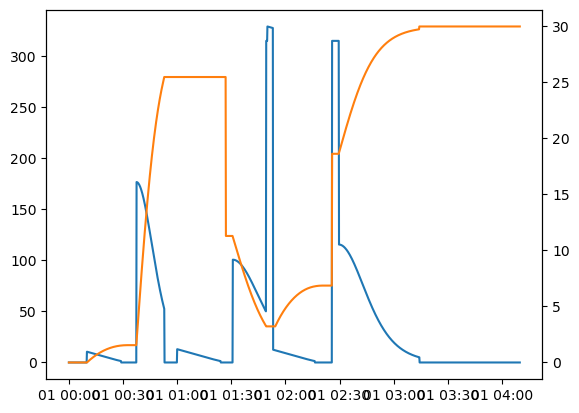

In [21]:
fig,ax = plt.subplots()
ax.plot(lock_1.discharge_saline.TIME.values[0:1500],lock_1.discharge_saline.values[0:1500])
ax2 = ax.twinx()
ax2.plot(lock_1.discharge_saline.TIME.values[0:1500],lock_1.salinity.values[0:1500],color='C1')


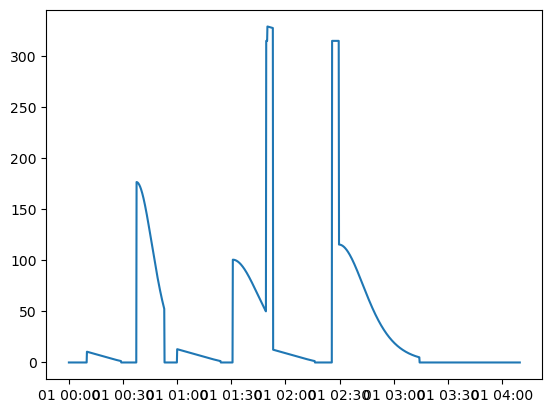

In [22]:
plt.plot(lock_1.discharge_saline.TIME.values[0:1500],lock_1.discharge_saline.values[0:1500])

In [23]:
pd.Timestamp(datetime.datetime(year=2019,month=1,day=1)).to_datetime64()

numpy.datetime64('2019-01-01T00:00:00.000000')

In [46]:
vessel_df = pd.DataFrame(vessels[0].log)
vessel_df

,Time,Location,Action,Status
0,2019-01-01 00:00:00.000000,POINT (45087.207657157356 373228.9573939128),Sailing from node Node_1 to node Node_2 start,"{'origin': '', 'destination': '', 'route': [],..."
1,2019-01-01 00:00:00.000000,POINT (45087.207657157356 373228.9573939128),Sailing to start of line-up area start,{}
2,2019-01-01 00:02:55.000000,POINT (45382.9747604719 372594.51132008387),Sailing to start of line-up area stop,{}
3,2019-01-01 00:02:55.000000,POINT (45382.9747604719 372594.51132008387),Sailing to position in line-up area start,{}
4,2019-01-01 00:04:01.666667,POINT (45467.4796471332 372413.2410132756),Sailing to position in line-up area stop,{}
5,2019-01-01 00:04:01.666667,POINT (45467.4796471332 372413.2410132756),Waiting in line-up area start,{}
6,2019-01-01 00:42:20.000000,POINT (45467.4796471332 372413.2410132756),Waiting in line-up area stop,{}
7,2019-01-01 00:42:20.000000,POINT (45467.4796471332 372413.2410132756),Sailing to end of line-up area start,{}
8,2019-01-01 00:44:11.111111,POINT (45509.732090463855 372322.6058598715),Sailing to end of line-up area stop,{}
9,2019-01-01 00:44:11.111111,POINT (45509.732090463855 372322.6058598715),Sailing to first set of lock doors start,{}


In [24]:
lock_df = pd.DataFrame(lock_1.log)
lock_df

,Time,Location,Action,Status
0,2019-01-01 00:00:00.000000,Node_2,Lock doors closing start,{}
1,2019-01-01 00:10:00.000000,Node_2,Lock doors closing stop,{}
2,2019-01-01 00:10:00.000000,Node_2,Lock chamber converting start,{}
3,2019-01-01 00:32:20.000000,Node_1,Lock chamber converting stop,{}
4,2019-01-01 00:32:20.000000,Node_1,Lock doors opening start,{}
5,2019-01-01 00:42:20.000000,Node_1,Lock doors opening stop,{}
6,2019-01-01 00:47:52.593802,Node_1,Lock doors closing start,{}
7,2019-01-01 00:57:52.593802,Node_1,Lock doors closing stop,{}
8,2019-01-01 00:57:52.593802,Node_1,Lock chamber converting start,{}
9,2019-01-01 01:25:42.593802,Node_2,Lock chamber converting stop,{}


In [33]:
window = pd.DataFrame(columns=['Start','Stop'])
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock doors opening start' and info.Location == 'Node_2':
        window.loc[len(window),'Start'] = info.Time
        
    elif info.Action == 'Lock doors closing stop' and info.Location == 'Node_2' and not window.empty:
        window.loc[len(window)-1,'Stop'] = info.Time

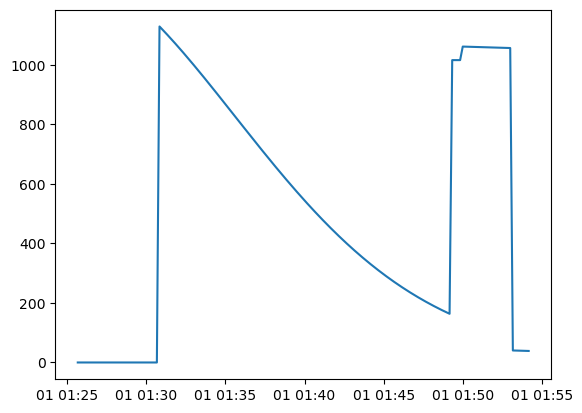

In [43]:
import scipy
import math
total_salt_intrusion = 0
for loc,info in window.iterrows():
    if pd.isnull(info.Start) or pd.isnull(info.Stop):
        continue
    window_start = np.absolute(lock_1.salinity.TIME.values-np.datetime64(info.Start)).argmin()
    window_end = np.absolute(lock_1.salinity.TIME.values-np.datetime64(info.Stop)).argmin()
    plt.plot(lock_1.salinity.TIME.values[window_start:window_end],
             lock_1.discharge_saline.values[window_start:window_end]*lock_1.salinity.values[window_start:window_end])
    plt.show()
    total_salt_intrusion += (lock_1.salinity[window_start].values-lock_1.salinity[window_end].values)*(lock_1.lock_length*lock_1.lock_width*lock_1.lock_depth)

In [44]:
total_salt_intrusion

2798991.9869450587

In [45]:
(total_salt_intrusion)/(lock_1.lock_length*lock_1.lock_width*lock_1.lock_depth*30)

0.7421205357236541